In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_text
from scipy import stats

# Connect and drop the first row of each dataFrame 

In [2]:
con = sqlite3.connect("Dataset/database.db")

awards_players_df = pd.read_sql_query("SELECT * FROM awards_players", con)
coaches_df = pd.read_sql_query("SELECT * FROM coaches", con)
players_teams_df = pd.read_sql_query("SELECT * FROM players_teams", con)
players_df = pd.read_sql_query("SELECT * FROM players", con)
series_post_df = pd.read_sql_query("SELECT * FROM series_post", con)
teams_df = pd.read_sql_query("SELECT * FROM teams", con)

awards_players_df = awards_players_df.tail(-1)
coaches_df = coaches_df.tail(-1)
players_teams_df = players_teams_df.tail(-1)
players_df = players_df.tail(-1)
series_post_df = series_post_df.tail(-1)
teams_df = teams_df.tail(-1)

In [13]:
playoffs_balance = teams_df['playoff'].value_counts()

print(playoffs_balance)

Y    80
N    62
Name: playoff, dtype: int64


The dataset is not perfectly balanced, but it is relatively close. It's generally desirable to have a balanced dataset, but slight imbalances like this may not pose a significant issue for many classification tasks.

# Clean the dataset

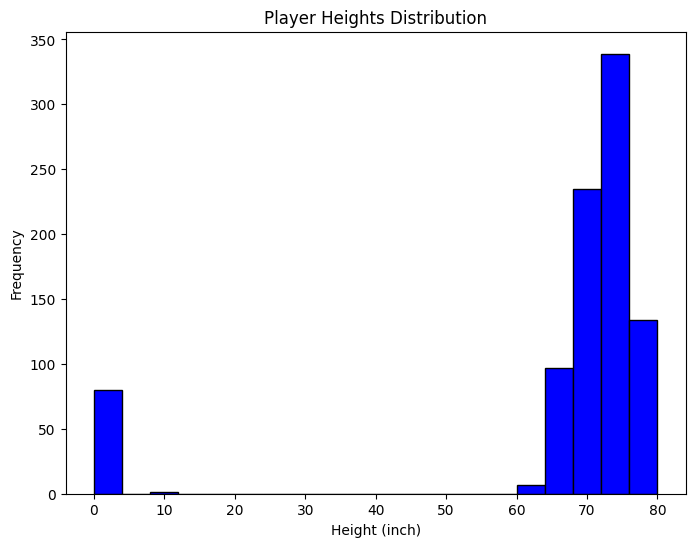

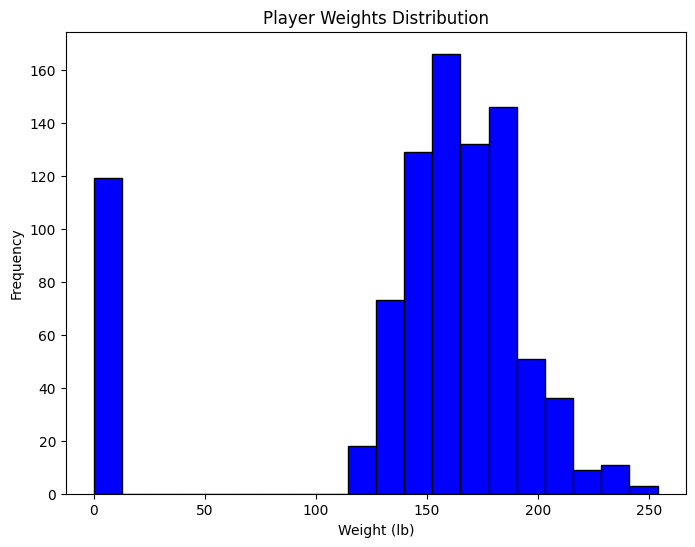

In [3]:
teams_df.dropna(inplace=True)
coaches_df.dropna(inplace=True)
players_df.dropna(inplace=True)
series_post_df.dropna(inplace=True)
players_teams_df.dropna(inplace=True)
awards_players_df.dropna(inplace=True)

plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

Since the players that have less than 20inch have all the other information as 0's and don't belong to any team in any season, these players will be dropped from the dataset.

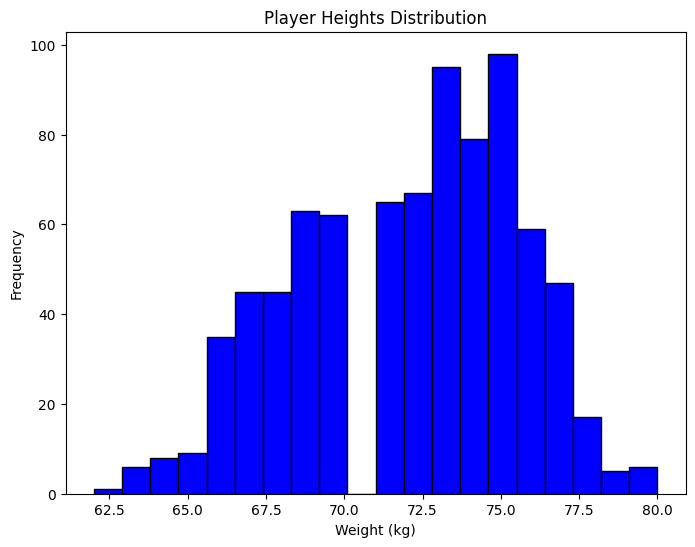

In [4]:
players_df = players_df[players_df['height'] >= 20]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

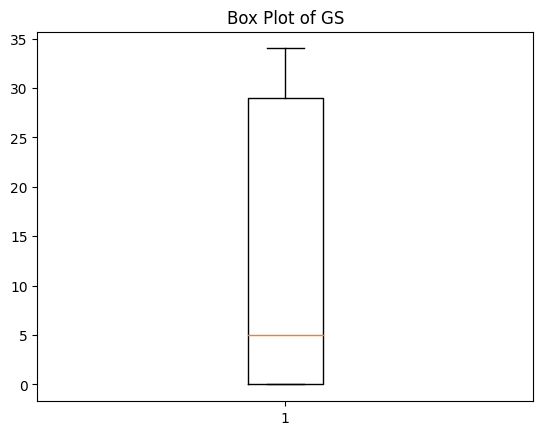

In [11]:
plt.boxplot(players_teams_df['GS'])
plt.title('Box Plot of GS')
plt.show()

In [12]:
# Check for missing values
awards_players_missing = awards_players_df.isnull().sum()

coaches_missing = coaches_df.isnull().sum()

players_teams_missing = players_teams_df.isnull().sum()

players_missing = players_df.isnull().sum()

series_post_missing = series_post_df.isnull().sum()

teams_missing = teams_df.isnull().sum()

# Print the results for each DataFrame
print("Missing values in awards_players_df:")
print(awards_players_missing)

print("Missing values in coaches_df:")
print(coaches_missing)

print("Missing values in players_teams_df:")
print(players_teams_missing)

print("Missing values in players_df:")
print(players_missing)

print("Missing values in series_post_df:")
print(series_post_missing)

print("Missing values in teams_df:")
print(teams_missing)

Missing values in awards_players_df:
playerID    0
award       0
year        0
lgID        0
dtype: int64
Missing values in coaches_df:
coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64
Missing values in players_teams_df:
playerID              0
year                  0
stint                 0
tmID                  0
lgID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fAttempted            0
fgMade                0
ftattempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0
PostGS                0
PostMinutes           0
PostPoints    

As can be seen in the output of the last cell, the dataset has no missing values so there's no need to replace any of them.

In [25]:
columns_to_drop = players_teams_df.filter(like='Post', axis=1).columns
players_teams_df = players_teams_df.drop(columns=columns_to_drop)

players_teams_df.head()


,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,0,MIN,WNBA,26,23,846,343,43,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,0,MIN,WNBA,27,27,805,314,45,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,0,MIN,WNBA,30,25,792,318,44,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,0,MIN,WNBA,22,11,462,146,17,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,0,MIN,WNBA,31,31,777,304,29,...,6,80,86,276,109,73,53,82,33,0


Since we only want to know which teams are more likely to get to the playoffs, there is no need in having the information associated to the playoffs of the previous seasons. Therefore, the columns that contain this information will be dropped.

In [28]:
duplicate_records = players_teams_df.duplicated(keep='first')

# Original DataFrame shape (before removing duplicates)
original_shape = players_teams_df.shape

# Shape of the DataFrame after removing duplicates
new_shape = duplicate_records.shape

# Calculate the number of duplicates dropped
duplicates_dropped = original_shape[0] - new_shape[0]

# Print the number of duplicates dropped
print(f"Number of duplicates dropped: {duplicates_dropped}")


illogical_records = players_teams_df[players_teams_df['GS'] > players_teams_df['GP']]
illogical_count = len(illogical_records)

print(f"Number of illogical values: {illogical_count}")

Number of duplicates dropped: 0
Number of illogical values: 0


In [20]:
zero_gp_count = players_teams_df[players_teams_df['minutes'] == 0].groupby('year')['playerID'].count()

print(zero_gp_count)

year
9    3
Name: playerID, dtype: int64


In [24]:
teams_df_clean = teams_df[['year', 'tmID', 'confID', 'attend']]

for index, row in coaches_df.iterrows():
    year = row['year']
    tmID = row['tmID']
    coachID = row['coachID']
    won = row['won']
    lost = row['lost']

    matching_row = teams_df[(teams_df['year'] == year) & (teams_df['tmID'] == tmID)]
    if not matching_row.empty:
        teams_df.loc[matching_row.index, 'coachID'] = coachID
        teams_df.loc[matching_row.index, 'coachWins'] = won
        teams_df.loc[matching_row.index, 'coachLosses'] = lost


players_teams_df = players_teams_df.drop([ 'stint', 'lgID'], axis = 1)

for index, row in players_df.iterrows():
    players_df['seasonNumber'] = len(players_teams_df.loc[players_teams_df['playerID'] == row['bioId']])
    for column in players_teams_df:
        if((column != 'playerID') and (column != 'year') and (column != 'tmID')):
            result = players_teams_df.loc[players_teams_df['playerID'] == row['bioId'], column].mean()
            if(pd.isna(result)):
                players_df.loc[index, column] = 0
            else:
                players_df.loc[index, column] = result


for index, row in teams_df.iterrows():
    print(row['tmID'])
    print(row['year'])
    matching_row = players_df[(players_df['tmID'] == row['tmID']) & (players_df['year'] == row['year'])]
    # if not matching_row.empty:
    #     players_df.loc[matching_row.index, 'coachID'] = row['coachID']
    #     players_df.loc[matching_row.index, 'coachWins'] = row['coachWins']
    #     players_df.loc[matching_row.index, 'coachLosses'] = row['coachLosses']


players_df.head()







ATL
9


KeyError: 'tmId'

In [47]:
teams_df["playoff"] = teams_df["playoff"].map({"N": 0, "Y": 1})

X = teams_df.drop('playoff', axis=1)
y = teams_df['playoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy: .2f}")

print(classification_report(y_test, y_pred))

tree_rules = export_text(clf, feature_names=list(X.columns))
print("Decision Tree Rules:")
print(tree_rules)


ValueError: could not convert string to float: 'WNBA'